# Integrate Langfuse with the Strands Agents SDK
[Strands Agent](https://strandsagents.com/) is a simple-to-use, code-first framework for building agents.

Strands natively integrates with OpenTelemetry, an industry standard for distributed tracing. This integration provides:

1. Compatibility with existing observability tools: Send traces to platforms like Jaeger, Grafana Tempo, AWS X-Ray, Datadog, and more
1. Standardized attribute naming: Using the OpenTelemetry semantic conventions
1. Flexible export options: Console output for development, OTLP endpoint for production
1. Auto-instrumentation: Trace creation is handled automatically when you enable tracing

## Dependencies (Warnings are safe to ignore)

In [ ]:
%pip uninstall -q -y autogluon-multimodal autogluon-timeseries autogluon-features autogluon-common autogluon-core
%pip install -Uq dotenv==0.9.9
%pip install -Uq mcp==1.9.3
%pip install -Uq strands-agents==0.1.4
%pip install -Uq strands-agents-tools==0.1.4
%pip install -Uq langfuse==2.60.8
%pip install -U uv==0.7.12

## This cell will restart the kernel. Wait for the pop-up box to appear, then click "OK" before proceeding.

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

## LLM Observability via OpenTelemetry and Langfuse

[OpenTelemetry](https://opentelemetry.io/) is a [CNCF](https://www.cncf.io/) project that provides a set of specifications, APIs, libraries that define a standard way to collect distributed traces and metrics from your application.

Langfuse can operate as an OpenTelemetry Backend to receive traces on the /api/public/otel (OTLP) endpoint. In addition to the Langfuse SDKs and native integrations, this OpenTelemetry endpoint is designed to increase compatibility with frameworks, libraries, and languages beyond the SDKs and native integrations. Popular OpenTelemetry libraries include OpenLLMetry and OpenLIT which extend Language support of Langfuse tracing to Java and Go and cover frameworks such as AutoGen, Semantic Kernel, and more.

In [ ]:
import os
import litellm

LANGFUSE_SECRET_KEY="<<YOUR LANGFUSE SECRET KEY>>"
LANGFUSE_PUBLIC_KEY="<<YOUR LANGFUSE PUBLIC_KEY>>"

os.environ["LANGFUSE_SECRET_KEY"] = LANGFUSE_SECRET_KEY
os.environ["LANGFUSE_PUBLIC_KEY"] = LANGFUSE_PUBLIC_KEY
os.environ["LANGFUSE_HOST"]="https://us.cloud.langfuse.com" # US data region
#os.environ["LANGFUSE_HOST"]="https://cloud.langfuse.com" # EU data region

# Configure callbacks
litellm.success_callback = ["langfuse"]
litellm.failure_callback = ["langfuse"]


In [ ]:
# OpenTelemetry setup
import base64


# Set up endpoint for OpenTelemetry
otel_endpoint = str(os.environ.get("LANGFUSE_HOST")) + "/api/public/otel/v1/traces"
 
# Create authentication token for OpenTelemetry
auth_token = base64.b64encode(f"{os.environ.get("LANGFUSE_PUBLIC_KEY")}:{os.environ.get("LANGFUSE_SECRET_KEY")}".encode()).decode()
os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = otel_endpoint
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"Authorization=Basic {auth_token}"

os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"], os.environ["OTEL_EXPORTER_OTLP_HEADERS"]

## Run a simple Strands Agent

In [ ]:
from strands_tools import python_repl, file_write
from strands import Agent, tool
import os

os.environ["BYPASS_TOOL_CONSENT"] = "true"

agent = Agent(tools=[python_repl, file_write],
              trace_attributes={
                "session.id": "abc-1234", # Example session ID
                "user.id": "user-email-example@domain.com", # Example user ID
                "langfuse.tags": [
                    "Agent-SDK-Example",
                    "Strands-Project-Demo",
                    "Observability-Tutorial"
                ]
                }
             )

prompt = """
Get the titles and the links of the articles listed in https://news.ycombinator.com/news. 
When you execute a python script, make sure to run it in non-interactive mode.
Write the results as a CSV file names news_{date}.csv.
"""

response = agent(prompt)

## Using MCP server as a tool

In [ ]:
from mcp import StdioServerParameters, stdio_client
from strands import Agent
from strands.models import BedrockModel
from strands.tools.mcp import MCPClient
from IPython.display import Image, display # Import for displaying images
import os # To check if the file exists
# It's good practice to import AgentResult if you know that's what's returned
# from strands.types import AgentResult # Or wherever it's defined in your strands version

aws_docs_client = MCPClient(
    lambda: stdio_client(
        StdioServerParameters(
            command="uvx", args=["awslabs.aws-documentation-mcp-server@latest"]
        )
    )
)

aws_diag_client = MCPClient(
    lambda: stdio_client(
        StdioServerParameters(
            command="uvx", args=["awslabs.aws-diagram-mcp-server@latest"]
        )
    )
)


bedrock_model = BedrockModel(
    model_id="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0.7,
)

SYSTEM_PROMPT = """
You are an expert AWS Certified Solutions Architect. Your role is to help customers understand best practices on building on AWS. 
You can query the AWS Documentation and generate diagrams. When you generate a diagram, 
you MUST create the diagram in the same folder where the code is running.".
"""

Use the **@observe()** decorator to give contexts to the trace.

In [ ]:
from langfuse.decorators import observe, langfuse_context

@observe(name="Strands-AWS-recommends")
def get_aws_recommends(query):
    with aws_docs_client, aws_diag_client:
        all_tools = aws_docs_client.list_tools_sync() + aws_diag_client.list_tools_sync()
        agent = Agent(tools=all_tools, 
                      model=bedrock_model, 
                      system_prompt=SYSTEM_PROMPT,
                      trace_attributes={
                           "existing_trace_id": langfuse_context.get_current_trace_id(),   # set langfuse trace ID
                           "parent_observation_id": langfuse_context.get_current_observation_id(),
                      })    
        # The agent() call returns an AgentResult object directly
        agent_result = agent(query)

get_aws_recommends("How to auto-scale workloads on EC2 instances? Suggest an architecture.")

Open your Langfuse project page and check if the traces were created:

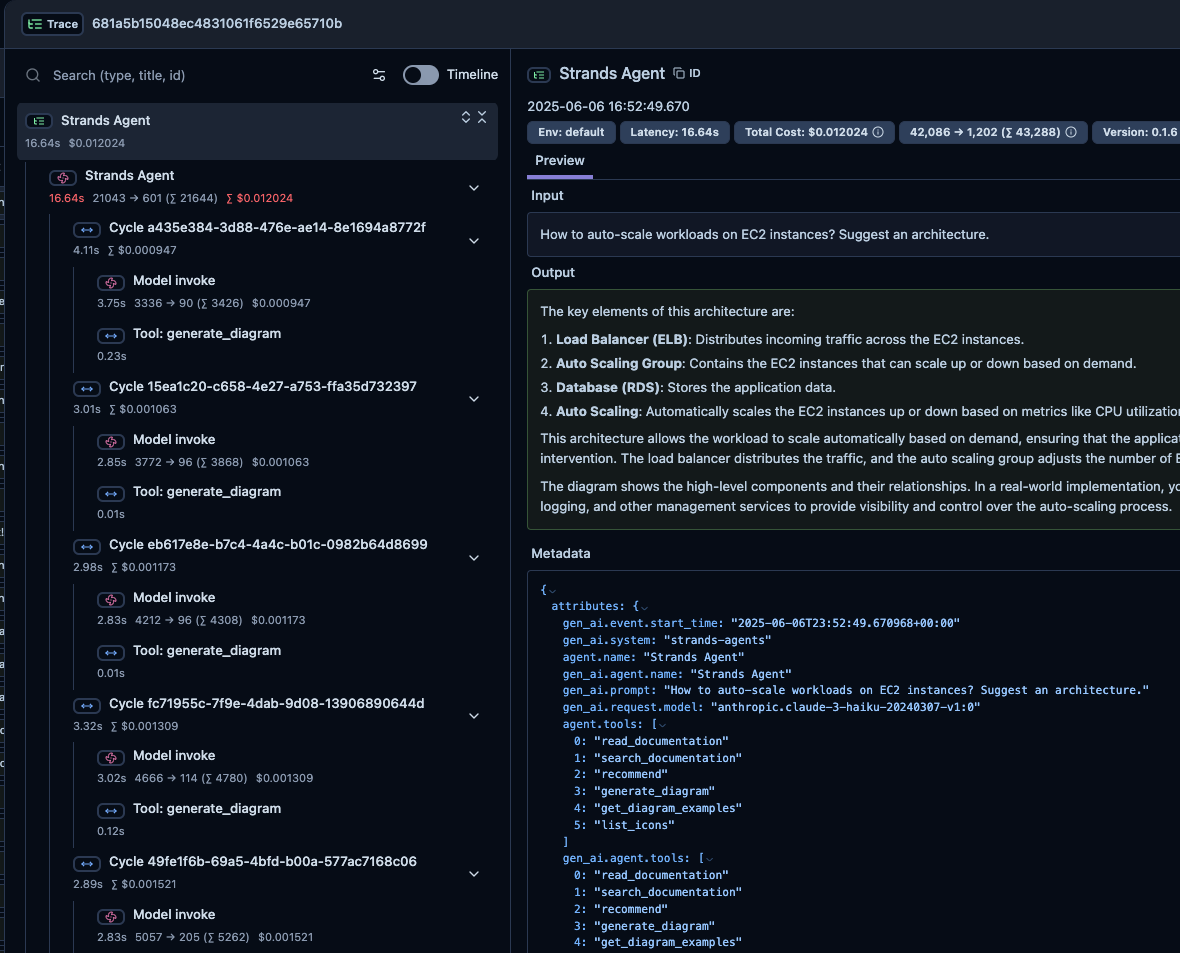